* Set objective function to glucose minimization
* Set upper bounds for biomass: 0.05, 0.10, 0.15, 0.20, 0.25, 0.30 (0.30 is max Rhodotorula growth rate in lab)
* Find PPP enzymes fluxes: 'TALA'=Transaldolase, 'TKT1'=Transketolase, 'TKT2'=Transketolase, 'RPI'=Ribose-5-phosphate isomerase (RKI - vist), 'G6PDH2rp'=Glucose 6-phosphate dehydrogenase (ZWF), 'GND'=Phosphogluconate dehydrogenase (GND), 'PGLp'=6-phosphogluconolactonase
* And find ATPM & ACITL fluxes


In [27]:
import cobra
import pandas as pd
import os
from os.path import join
from cobra import Model, Reaction, Metabolite
from cobra.sampling import sampling
import numpy as np
os.environ["R_HOME"] = f"{os.environ['CONDA_PREFIX']}\\Lib\\R"
import rpy2.robjects
from plotnine import *
import matplotlib.pyplot as plt


In [28]:
# Importing the model
model=cobra.io.read_sbml_model("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\Rt_IFO0880.xml")


In [29]:
# Changing the objective function
model.objective = "EX_glc__D_e" 
solution = model.optimize('minimize') # minimize the objective function
solution.objective_value # get the objective value i.e flux of the objective function
# print(model.objective.expression)
# print(model.objective.direction)
# solution

-1.0

In [38]:
# Change glucose bounds
model.reactions.get_by_id("EX_glc__D_e").upper_bound = 9999
model.reactions.get_by_id("EX_glc__D_e").lower_bound = -9999

In [40]:
# Get all fluxes
all_fluxes = solution.fluxes.to_frame(name='Flux') # solution.fluxes gives fluxes for all reactions, to_frame makes it a pandas dataframe
all_fluxes 

,Flux
ALCD25yi,0.0
MTHFCm,0.0
AMPN,0.0
DAGCPTer_RT,0.0
PYRt2,0.0
...,...
FOLt,0.0
NADtm,0.0
EX_pydxn_e,0.0
PYDXNtr,0.0


In [41]:
# Get all fluxes on different GR
GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
flux_values_specific_GR = pd.DataFrame(columns=['GR', *all_fluxes.index], index=range(len(GR_range))) #flux_values.index gives the row names column, * extracts the list of strings

for i in range(len(GR_range)):
    model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
    solution = model.optimize('minimize')
    flux_values_specific_GR.loc[i] = solution.fluxes[['BIOMASS_RT', *all_fluxes.index]].values
# Example for finding a certain reaction flux: flux_values_specific_GR['EX_o2_e']
# flux_values_specific_GR

In [42]:
def fluxes_on_specific_GR(model, GR_range, enzymes, minimize = True):
    fluxes = pd.DataFrame(columns=['GR', *enzymes], index=range(len(GR_range)))
    for i in range(len(GR_range)):
        model.reactions.BIOMASS_RT.bounds = GR_range[i], GR_range[i]
        solution = model.optimize('minimize' if minimize else 'maximize')        
        fluxes.loc[i] = solution.fluxes[['BIOMASS_RT', *enzymes]].values
    return fluxes

In [43]:
# Fluxes for ATPM and ACITL
GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
enzymes = ['ATPM', 'ACITL']
ATPM_ACITL_fluxes = fluxes_on_specific_GR(model, GR_range, enzymes)
ATPM_ACITL_fluxes


,GR,ATPM,ACITL
0,0.05,1.22,0.0
1,0.1,1.22,0.0
2,0.15,1.22,0.0
3,0.2,1.22,0.0
4,0.25,1.22,0.0
5,0.3,1.22,0.0


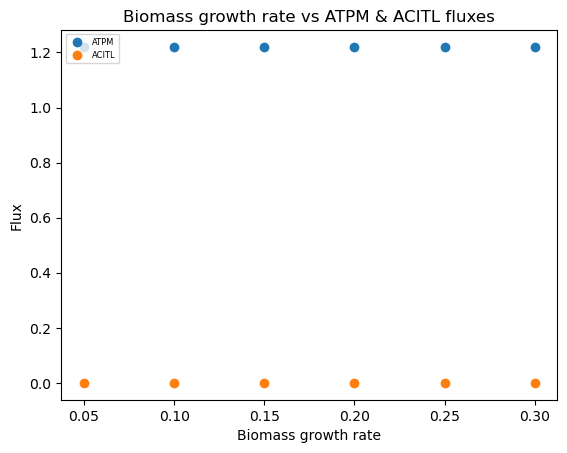

In [44]:
plt.plot(GR_range, np.abs(ATPM_ACITL_fluxes[['ATPM', 'ACITL']]), 'o', label=['ATPM', 'ACITL'])
plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Biomass growth rate vs ATPM & ACITL fluxes")
plt.legend(fontsize=6, loc='upper left')
plt.show()

In [45]:
# Get fluxes for PPP enzymes
# add phosphoketolase 'XPK', pyruvate decarboxylase 'PYRDC', pyruvate dehydrogenase 'PDHm'

GR_range= [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]
enzymes = ['TALA', 'TKT1', 'TKT2', 'RPI', 'G6PDH2rp', 'GND','PGLp','XPK','PYRDC','PDHm']
PPP_enzymes_fluxes = fluxes_on_specific_GR(model, GR_range, enzymes)
# PPP_enzymes_fluxes


In [46]:
# Add the values together that are the same - oxpp> all these four are the same, get their absolute value
# oxpp
PPP_enzymes_fluxes['oxpp'] = (PPP_enzymes_fluxes.G6PDH2rp + PPP_enzymes_fluxes.PGLp + PPP_enzymes_fluxes.GND + PPP_enzymes_fluxes.RPI)/4
PPP_enzymes_fluxes

,GR,TALA,TKT1,TKT2,RPI,G6PDH2rp,GND,PGLp,XPK,PYRDC,PDHm,oxpp
0,0.05,0.0,-7.170386,14.247339,7.077127,0.0,0.0,0.0,0.0,0.0,0.0,1.769282
1,0.1,0.0,-13.730772,27.274678,13.544255,0.0,0.0,0.0,0.0,0.0,0.0,3.386064
2,0.15,0.0,-20.291157,40.302017,20.011382,0.0,0.0,0.0,0.0,0.0,0.0,5.002845
3,0.2,0.0,-26.851543,53.329356,26.478509,0.0,0.0,0.0,0.0,0.0,0.0,6.619627
4,0.25,0.0,-33.411929,66.356695,32.945637,0.0,0.0,0.0,0.0,0.0,0.0,8.236409
5,0.3,0.0,-39.972315,79.384034,39.412764,0.0,0.0,0.0,0.0,0.0,0.0,9.853191


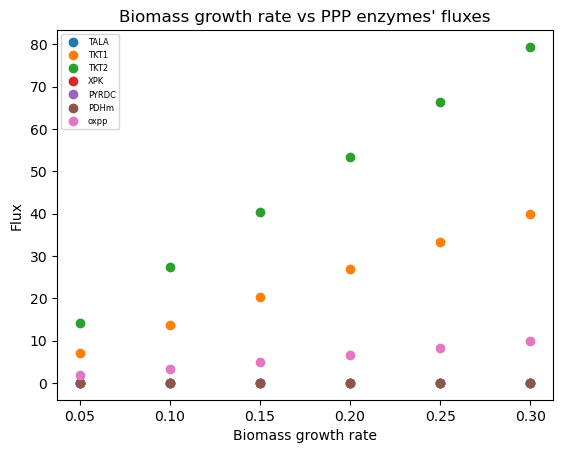

In [47]:
# Plot the PPP enzymes fluxes

plt.plot(PPP_enzymes_fluxes['GR'], np.abs(PPP_enzymes_fluxes[['TALA', 'TKT1',	'TKT2',	'XPK','PYRDC','PDHm', 'oxpp']]), 'o', label=['TALA', 'TKT1', 'TKT2','XPK','PYRDC','PDHm', 'oxpp'])
plt.xlabel('Biomass growth rate')
plt.ylabel('Flux')
plt.title("Biomass growth rate vs PPP enzymes' fluxes")
plt.legend(fontsize=6, loc='upper left')
plt.show()

# exchange_fluxes_all = model.summary().to_frame()
# exchange_fluxes_all = exchange_fluxes_all[abs(exchange_fluxes_all['flux']) != 0.01]
# exchange_fluxes_all = exchange_fluxes_all[['metabolite', 'flux']]
# # exchange_fluxes_all

In [48]:
# # Export DataFrames to excel - NB! Will overwrite the pages
# with pd.ExcelWriter("C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Results\\Simulated_fluxes\\PPP_fluxes.xlsx") as excel_writer:
#     PPP_enzymes_fluxes.to_excel(excel_writer, sheet_name='Sheet1', index=False)
#     ATPM_ACITL_fluxes.to_excel(excel_writer, sheet_name='Sheet2', index=False)


In [ ]:
# from pathlib import Path
# from cobra.io import load_json_model, save_json_model, load_matlab_model, save_matlab_model, read_sbml_model, write_sbml_model
# import logging
# save_json_model(model, "C:\\Users\\Maive\\Desktop\\BSc_loputoo\\Model_files\\edited_model.json")